** pip install sk-video **

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

height, width = 64, 64

# Display Image
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
def display_images(output_image):
    fig = plt.figure(figsize=(height, width))  # width, height in inches
    for i in range(64):
        sub = fig.add_subplot(8, 8, i + 1)
        sub.imshow(output_image[i], interpolation='nearest')

In [2]:
import skvideo.io
import skvideo.datasets
videodata = skvideo.io.vread("UCF-101/Archery/v_Archery_g05_c01.avi")

/home/pratik/anaconda2/lib/python2.7/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [3]:
print (videodata.shape)

(455, 240, 320, 3)


In [4]:
import cv2
frames = []
for each_frame in videodata:
    resized_image = cv2.resize(each_frame, (64,64))
    frames.append(resized_image)
frames = np.array(frames)

In [5]:
frames.shape

(455, 64, 64, 3)

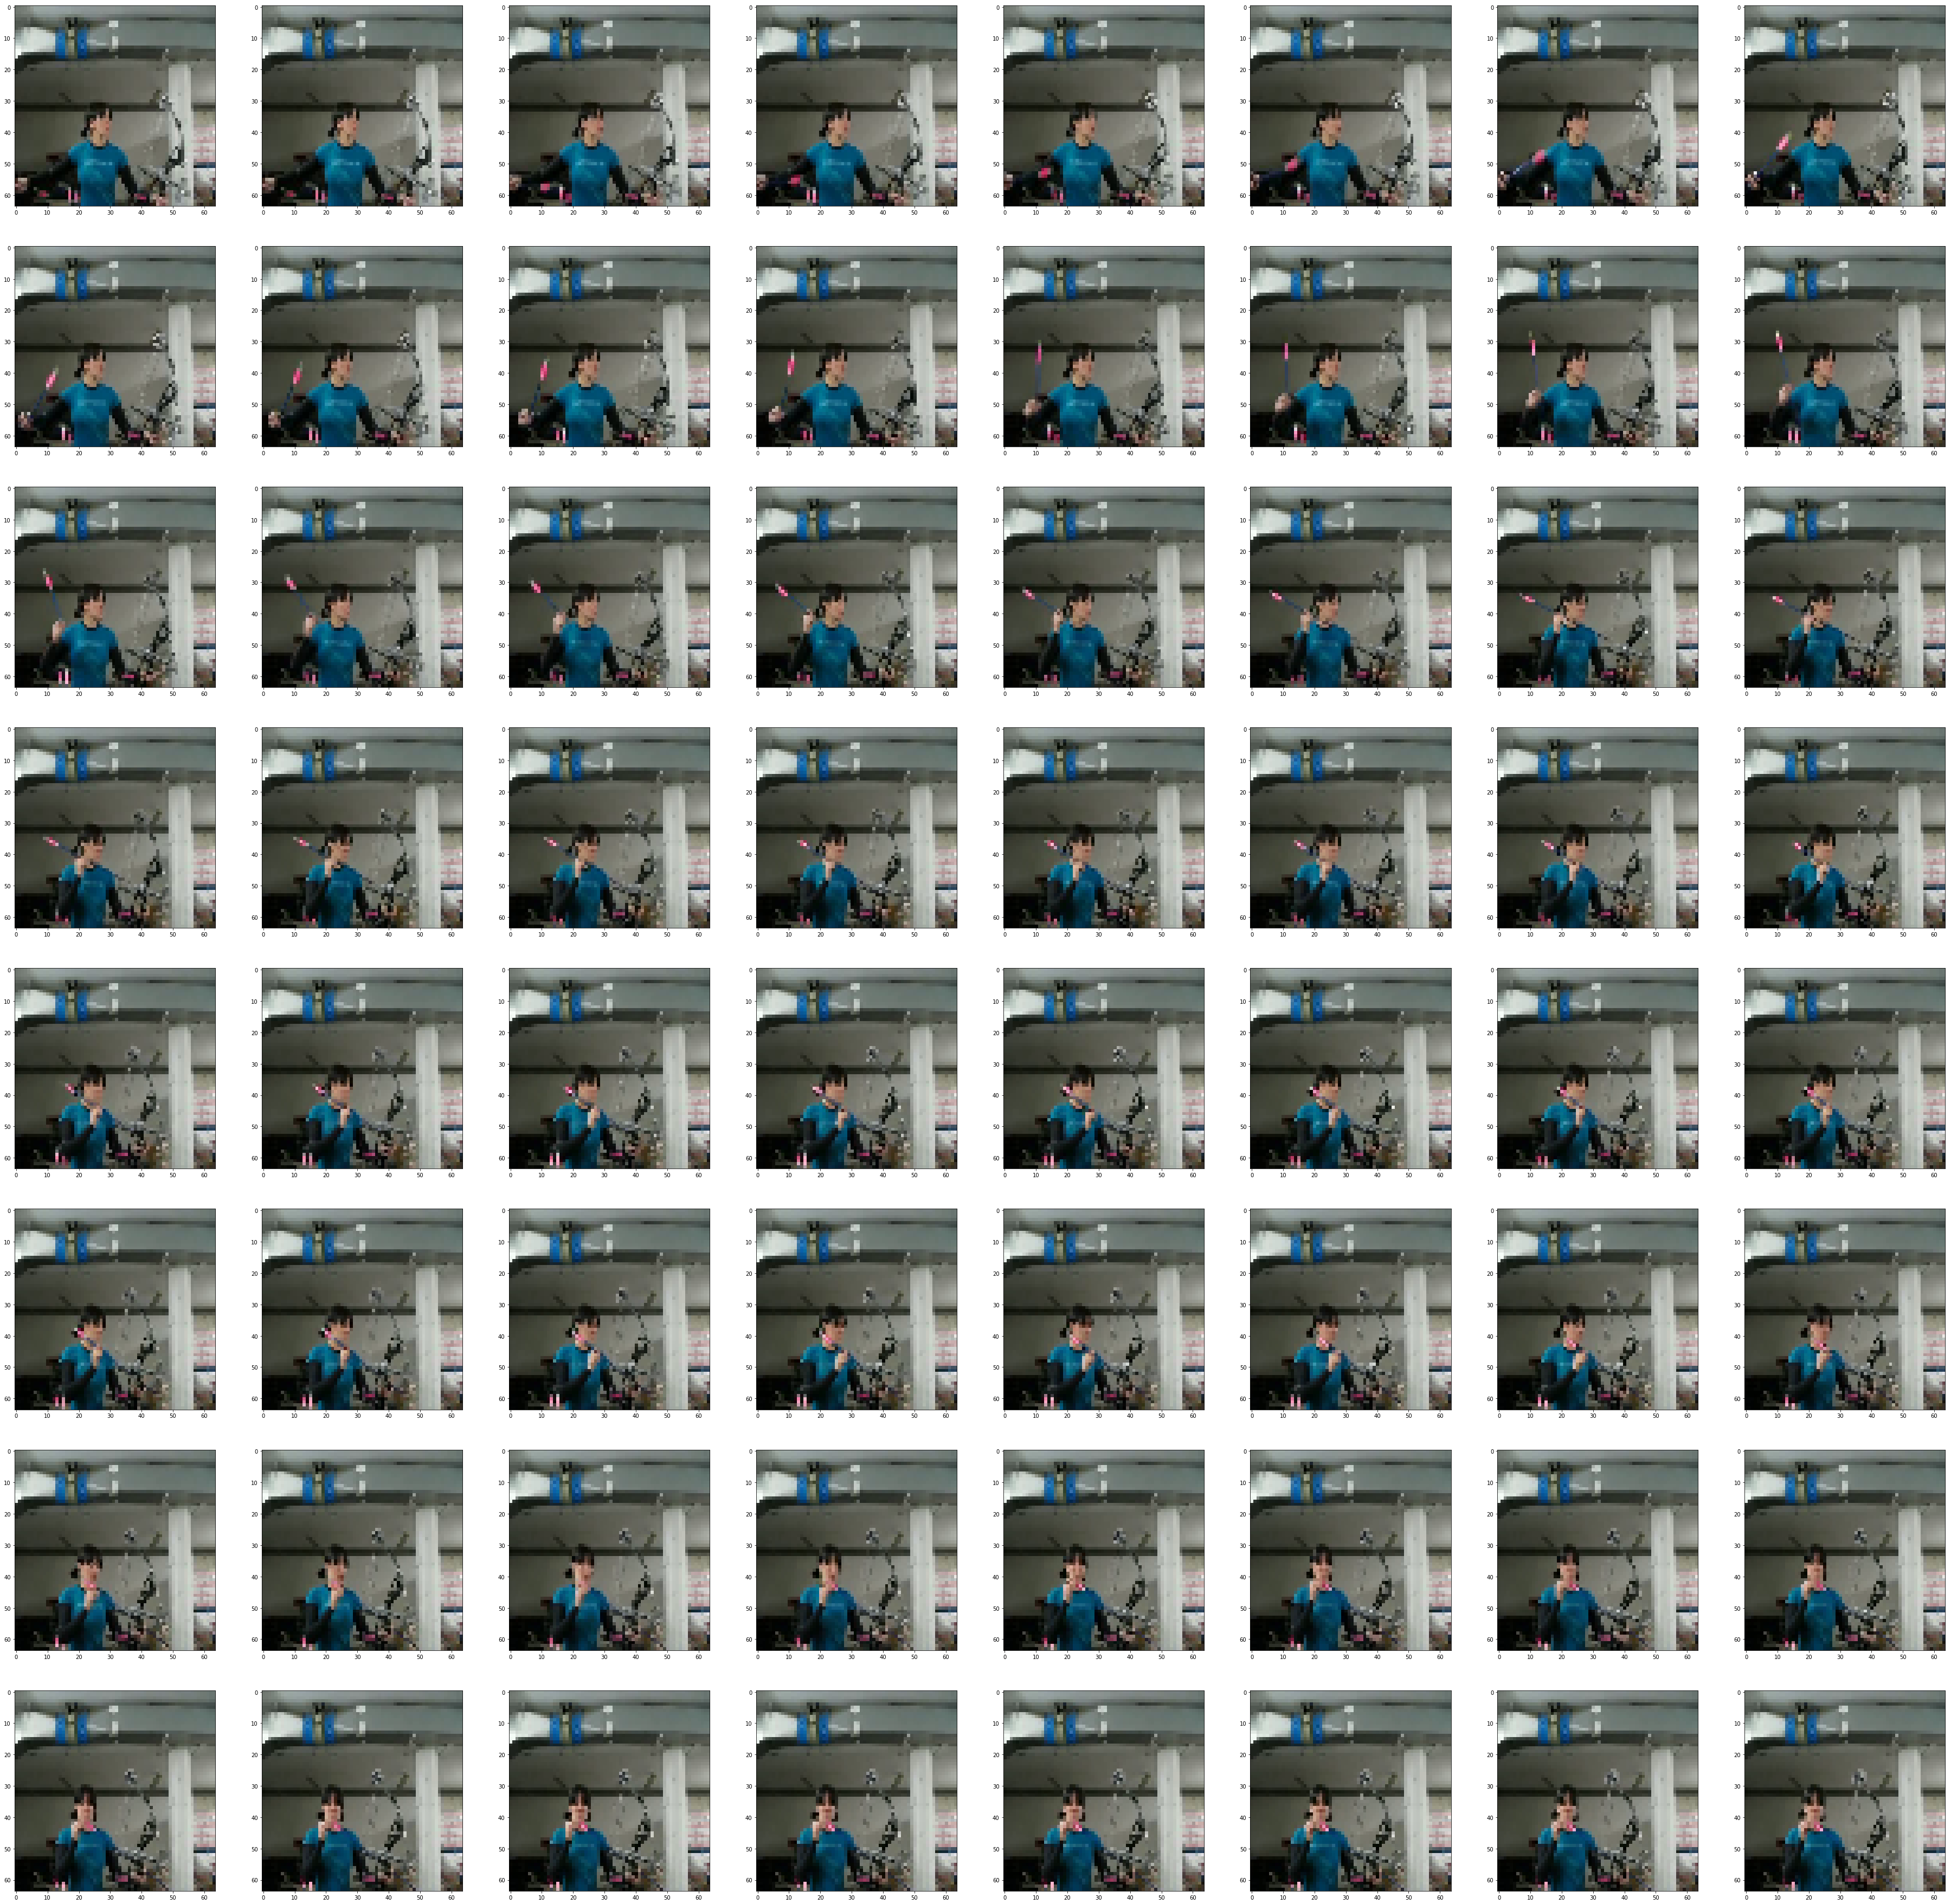

In [6]:
display_images(frames)

In [68]:
# TensorFlow Model !
import tensorflow as tf

# Run when your in trouble ... !
tf.reset_default_graph()

batch_size = 128
timesteps = 32
shape = [64, 64]
kernel = [3, 3]
channels = 3
filters = 12

In [69]:
# Create a placeholder for videos.
inputs = tf.placeholder(tf.float32, [batch_size, timesteps] + shape + [channels]) # (batch_size, timestep, H, W, C)
outputs_exp = tf.placeholder(tf.float32, [batch_size, timesteps] + shape + [channels] ) # (batch_size, timestep, H, W, C)

In [70]:
# Add the ConvLSTM step.
from cell import ConvLSTMCell
cell = ConvLSTMCell(shape, filters, kernel)
outputs, state = tf.nn.dynamic_rnn(cell, inputs, dtype=inputs.dtype)

In [74]:
print(inputs)
print (outputs_exp)
print(outputs)
print (state)

Tensor("Placeholder:0", shape=(128, 32, 64, 64, 3), dtype=float32)
Tensor("Placeholder_1:0", shape=(128, 32, 64, 64, 3), dtype=float32)
Tensor("rnn/transpose:0", shape=(128, 32, 64, 64, 12), dtype=float32)
LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(128, 64, 64, 12) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(128, 64, 64, 12) dtype=float32>)


** ADD intial_state in dynamic_rnn below ..., remove dtype **

** Name scopping **

    with tf.variable_scope('lstm1'):
          output, state = tf.nn.rnn_cell.BasicLSTMCell(3)(input, init_state)
    with tf.variable_scope('lstm2'):
          output2, state2 = tf.nn.rnn_cell.BasicLSTMCell(3)(input2, init_state2)

** DroupOut ... is there anywhere place to add **

** Does output requires W, b multiplication again ... ??? **

In [72]:
filters = [32,128,32,3]
cells = []
# Multi Layer LSTM
# Iterate over each layer ... 
for i, each_filter in enumerate(filters):
    cell = ConvLSTMCell(shape, each_filter, kernel)
    cells.append(cell)
    
cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell,inputs,dtype=tf.float32)

In [73]:
print (states_series)
print (current_state)

Tensor("rnn_1/transpose:0", shape=(128, 32, 64, 64, 3), dtype=float32)
(LSTMStateTuple(c=<tf.Tensor 'rnn_1/while/Exit_2:0' shape=(128, 64, 64, 32) dtype=float32>, h=<tf.Tensor 'rnn_1/while/Exit_3:0' shape=(128, 64, 64, 32) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn_1/while/Exit_4:0' shape=(128, 64, 64, 128) dtype=float32>, h=<tf.Tensor 'rnn_1/while/Exit_5:0' shape=(128, 64, 64, 128) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn_1/while/Exit_6:0' shape=(128, 64, 64, 32) dtype=float32>, h=<tf.Tensor 'rnn_1/while/Exit_7:0' shape=(128, 64, 64, 32) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn_1/while/Exit_8:0' shape=(128, 64, 64, 3) dtype=float32>, h=<tf.Tensor 'rnn_1/while/Exit_9:0' shape=(128, 64, 64, 3) dtype=float32>))


In [76]:
# L2 Loss
frames_difference = tf.subtract(states_series,outputs_exp)
batch_l2_loss = tf.nn.l2_loss(frames_difference)
# divide by batch size ... 
l2_loss = tf.divide(batch_l2_loss, float(batch_size))

# Optimizer 
train_step = tf.train.AdamOptimizer().minimize(l2_loss)

In [78]:
print (l2_loss)

Tensor("truediv_1:0", shape=(), dtype=float32)


In [11]:
# Video pickling try
import os
import numpy as np
import cv2
import skvideo.io
import pickle
import time
start_time = time.time()

DIR = "../../data/"
data = {}
c = 0 
for path, subdirs, files in os.walk(DIR):
    for filename in files:
        f = os.path.join(path, filename)
        video_data = skvideo.io.vread(f)
        resized_frames = []
        for each_frame in video_data:
            resized_frames.append(cv2.resize(each_frame, (64,64)))
        resized_frames = np.array(resized_frames)
        # print (resized_frames.shape)
        data[f] = resized_frames
        c += 1
        if c%10==0:
            print ("Processing ", c) 
        # break
        
print ("Total ",c)

with open('../../data_map.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("--- %s seconds ---" % (time.time() - start_time))
# with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

('Processing ', 10)
('Processing ', 20)
('Processing ', 30)
('Processing ', 40)
('Processing ', 50)
('Processing ', 60)
('Processing ', 70)
('Processing ', 80)
('Processing ', 90)
('Processing ', 100)
('Processing ', 110)
('Processing ', 120)
('Processing ', 130)
('Processing ', 140)
('Processing ', 150)
('Processing ', 160)
('Processing ', 170)
('Processing ', 180)
('Processing ', 190)
('Processing ', 200)
('Processing ', 210)
('Processing ', 220)
('Processing ', 230)
('Processing ', 240)
('Processing ', 250)
('Processing ', 260)
('Processing ', 270)
('Processing ', 280)
('Processing ', 290)
('Processing ', 300)
('Processing ', 310)
('Processing ', 320)
('Processing ', 330)
('Processing ', 340)
('Processing ', 350)
('Processing ', 360)
('Processing ', 370)
('Processing ', 380)
('Processing ', 390)
('Processing ', 400)
('Total ', 404)
--- 85.55250597 seconds ---


In [1]:
import numpy as np
x = np.arange(10*455*64*64*3)
np.save("../../np_array_save",x)